# Importation Station

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.svm import LinearSVC, SVC
from imblearn.under_sampling import RandomUnderSampler

plt.style.use("seaborn")
%matplotlib inline

%load_ext autotime

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Make DataFrame and Extract Features

## Read Initial Data

In [2]:
# df= pd.read_csv("us-perm-visas.zip")
# df.head()

time: 738 µs


## Extract Features of Interest

In [3]:
# df_feat=df[['class_of_admission','country_of_citizenship',
#             'country_of_citzenship','case_status', 'employer_state','foreign_worker_info_city',
#             'foreign_worker_info_education','foreign_worker_info_major',
#            'application_type', 'fw_info_birth_country', 'job_info_alt_occ_job_title','job_info_education',
#             'wage_offer_from_9089']]
# df_feat.head()
# del df

time: 1.47 ms


# Pickle and Store Features of Interest into CSV

In [4]:
# with open('visa.pkl', 'wb') as picklefile:
#              pickle.dump(df_feat, picklefile)

time: 799 µs


In [5]:
# with open("visa.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('visa.csv')
# df.head()

time: 836 µs


# Read Pre-Made CSV File

In [6]:
df=pd.read_csv('visa.csv')
del(df['Unnamed: 0'])
#df.head()

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


time: 1.4 s


# Data Cleaning Pt.1

## Initial NA Counts

In [7]:
df.isnull().sum()
initial_na=df.isnull().sum()

time: 543 ms


## Remove Withdrawn Applications and Combine Expired with Certified

In [8]:
df=df[(df.case_status!='Withdrawn')]
df=df.replace({'Certified-Expired':'Certified'})

time: 882 ms


In [9]:
df.case_status.unique()

array(['Certified', 'Denied'], dtype=object)

time: 18.5 ms


## Combine Repeated Columns

In [10]:
df.country_of_citizenship.fillna(df.country_of_citzenship, inplace=True)
df=df.drop('country_of_citzenship', axis=1)
#df.isnull().sum()

time: 95.8 ms


In [11]:
df.foreign_worker_info_education.fillna(df.job_info_education, inplace=True)
df=df.drop('job_info_education', axis=1)
#df.isnull().sum()

time: 110 ms


## Fill Na's
**Idea:**
1. Ignore Target Variable When Filling NA's

**Structure for Each Variable:**
1. Read Values Counts
2. Fill in As Needed

In [12]:
def impute(df, series, col_name, merge_cols):
    merged_frame = pd.merge(df, series, how='left', 
                             left_on=merge_cols, 
                             right_on=merge_cols)
    merged_frame[col_name+'_x'].fillna(merged_frame[col_name+'_y'],inplace=True)
    merged_frame.rename(columns={col_name+'_x':col_name}, inplace=True)
    merged_frame.drop([col_name+'_y'], axis=1, inplace=True)
    return merged_frame

time: 3.36 ms


In [13]:
def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

time: 1.47 ms


### Country of Citizenship= Fill using the mode by education level

In [14]:
country_fill_series = df[~df['country_of_citizenship'].isnull()].groupby(['foreign_worker_info_education']
                                                                        ).country_of_citizenship.apply(mode
                                                                                                      ).reset_index()
#country_fill_series

time: 294 ms


In [15]:
df=impute(df, country_fill_series, 'country_of_citizenship',['foreign_worker_info_education'])
#df.isnull().sum()

time: 515 ms


### Destination State= Fill using overall mode

In [16]:
# df.employer_state.unique()

time: 805 µs


In [17]:
state_fill_series=df['employer_state'].mode()
# state_fill_series

time: 32.7 ms


In [18]:
df.employer_state.fillna('CALIFORNIA', inplace=True)
# df.isnull().sum()

time: 21.7 ms


### Origin City= Fill using mode of given country

In [19]:
# df.foreign_worker_info_city.unique()

time: 868 µs


In [20]:
origin_fill_series = df[~df['foreign_worker_info_city'].isnull()].groupby(['country_of_citizenship']
                                                                         ).foreign_worker_info_city.apply(mode
                                                                                                         ).reset_index()
# origin_fill_series

time: 308 ms


In [21]:
df = impute(df, origin_fill_series, 'foreign_worker_info_city',['country_of_citizenship'])
# df.isnull().sum()

time: 595 ms


### Education Level= Fill using Country and Visa Type

In [22]:
# df.foreign_worker_info_education.unique()

time: 791 µs


In [23]:
education_fill_series = df[~df['foreign_worker_info_education'].isnull()].groupby(['country_of_citizenship',
                                                                                   'class_of_admission']
                                                                                 ).foreign_worker_info_education.apply(mode
                                                                                                                      ).reset_index()
# education_fill_series

time: 447 ms


In [24]:
df = impute(df, education_fill_series, 'foreign_worker_info_education', ['country_of_citizenship',
                                                                                   'class_of_admission'])
# df.isnull().sum()

time: 529 ms


### Major= Fill with mode of visa type / country of origin / education / destination

In [25]:
# df.foreign_worker_info_major.value_counts()

time: 831 µs


In [26]:
major_fill_series = df[~df['foreign_worker_info_major'].isnull()].groupby(['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state']
                                                                             ).foreign_worker_info_major.apply(mode
                                                                                                              ).reset_index()
# major_fill_series

time: 2.45 s


In [27]:
df = impute(df, major_fill_series, 'foreign_worker_info_major',['country_of_citizenship',
                                                                               'class_of_admission',
                                                                               'foreign_worker_info_education',
                                                                               'employer_state'])
# df.isnull().sum()

time: 571 ms


### Birth Country= Fill with country of citizenship

In [28]:
# df.fw_info_birth_country.unique()

time: 876 µs


In [29]:
df.fw_info_birth_country.fillna(df.country_of_citizenship, inplace=True)
# df.isnull().sum()

time: 36.7 ms


### Job Title
1. Condense Job Titles into Categories
2. Fill in missing information using mode by major, education level, and class of admission

In [30]:
# df.job_info_alt_occ_job_title.value_counts()

time: 851 µs


In [31]:
def label(row,col):
    if type(row[col])!=float:
        value=row[col].lower()
        value_case_sensitive=row[col]
    else:
        value='null'
        value_case_sensitive='null'
    programmer=['comp', 'software','developer', 'program','soft','web','application development', 'data']
    it=['IT','Information Technology','technical']
    h14=['H.14', 'H-14','H14','H. 14', 'H:14']
    medicine=['health','doctor','pharm','therapist','surgery','acupunc', 'medic', 'dent', 'vet']
    engineer=['engr','engineer','eng', 'tech']
    marketing=['market','sale']
    finance=['financ', 'consult','account','tax','audit']
    other_biz=['analyst', 'business','anlyst','associate','manag','project']
    academic=['analys', 'assistant', 'research', 'teach','academic', 'educ']
    related=['related occupation', 'related', 'any', 'similar','experience', 'alternate']
    h11=['H-11','H11','H.11', 'H. 11']
    fourteen=['14']
    nan=['null']
    if value=='null' or value_case_sensitive=='null':
        return None
    if any(keyword in value for keyword in programmer):
        return 'programming'
    if any(keyword in value_case_sensitive for keyword in it):
        return 'IT'
    if any(keyword in value_case_sensitive for keyword in h14):
        return 'H.14'
    if any(keyword in value for keyword in medicine):
        return 'medicine'
    if any(keyword in value for keyword in engineer):
        return 'engineer'
    if any(keyword in value for keyword in marketing):
        return 'marketing/sales'
    if any(keyword in value for keyword in finance):
        return 'finance/consulting/tax'
    if any(keyword in value for keyword in other_biz):
        return 'business'
    if any(keyword in value for keyword in academic):
        return 'academic'
    if any(keyword in value_case_sensitive for keyword in h11):
        return 'h11'
    if any(keyword in value for keyword in related):
        return 'related'
    if any(keyword in value_case_sensitive for keyword in fourteen):
        return '14'
    return 'Other'

time: 7.67 ms


In [32]:
df['job_category']=df.apply (lambda row: label(row, 'job_info_alt_occ_job_title'),axis=1)
# df.job_category.value_counts()

time: 9.32 s


In [33]:
# df.job_info_alt_occ_job_title[df.job_category=="Other"].value_counts()

time: 524 µs


In [34]:
job_type_fill_series = df[~df['job_category'].isnull()].groupby(['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission']
                                                                             ).job_category.apply(mode).reset_index()
# job_type_fill_series

time: 3.58 s


In [35]:
df = impute(df, job_type_fill_series, 'job_category',['foreign_worker_info_major',
                                                                               'foreign_worker_info_education',
                                                                               'class_of_admission'])
# df.isnull().sum()

time: 884 ms


In [36]:
df=df.drop('job_info_alt_occ_job_title', axis=1)

time: 40.2 ms


### Visa Type (Class of Admission)

In [37]:
# df.class_of_admission.unique()

time: 1.51 ms


In [38]:
visa_fill_series = df[~df['class_of_admission'].isnull()].groupby(['foreign_worker_info_education'
                                                                  ]).class_of_admission.apply(mode).reset_index()
# visa_fill_series

time: 364 ms


In [39]:
df = impute(df, visa_fill_series, 'class_of_admission',['foreign_worker_info_education'])

time: 569 ms


### Drop Columns 

In [40]:
df=df.drop(['foreign_worker_info_major', 'fw_info_birth_country', 'application_type','wage_offer_from_9089'], axis=1)

time: 39.8 ms


### Final NA Counts Initial Dataset

In [41]:
df.isnull().sum()
final_na=df.isnull().sum()

time: 362 ms


# Data Cleaning Pt.2- Joining Tables to Reduce Categorical Data

## Change Cities to Population

In [42]:
cities_pop = pd.read_excel('global-city-population-estimates.xls', sheet_name='CITIES-OVER-300K')

time: 279 ms


In [43]:
city_df = cities_pop.loc[:,['Urban Agglomeration', '2015']].rename(columns = {'Urban Agglomeration': 'city', '2015': 'pop'})

time: 11.6 ms


In [44]:
city_df['city'] = city_df['city'].str.upper()
city_df.set_index('city', inplace=True)
city_df_dict = city_df.to_dict()

time: 15.6 ms


In [45]:
df['foreign_worker_city_pop'] = df['foreign_worker_info_city'].apply(lambda x: city_df_dict['pop'].get(x, x))

time: 209 ms


In [46]:
replacements={}
for city in df.loc[df['foreign_worker_city_pop'].apply(type)==str,'foreign_worker_city_pop' ]:
    for value in city_df.index:
        if city in value:
            replacements[city]=value

time: 34.1 s


In [47]:
df['foreign_worker_city_pop'] = df['foreign_worker_city_pop'].apply(lambda x: replacements.get(x,x)).apply(lambda x: city_df_dict['pop'].get(x, x))

time: 265 ms


In [48]:
df['foreign_worker_city_pop']= df['foreign_worker_city_pop'].apply(lambda x: 300 if type(x)==str else x)

time: 171 ms


In [49]:
df['foreign_worker_info_city']= df['foreign_worker_city_pop']

time: 65.3 ms


In [50]:
df=df.drop('foreign_worker_city_pop', axis=1)

time: 35.7 ms


In [51]:
df['foreign_worker_info_city'].fillna(50.000, inplace=True)

time: 6.12 ms


In [52]:
# df.loc[df['foreign_worker_city_pop'].apply(type)==str, 'foreign_worker_city_pop' ].value_counts()

time: 844 µs


In [53]:
# df['foreign_worker_city_pop'].value_counts()

time: 1 ms


## Fixing Duplicates in States

In [54]:
state_list = pd.read_html('https://www.infoplease.com/state-abbreviations-and-state-postal-codes')
state_abbr = pd.concat([state_list[0],state_list[1]], axis=0).reset_index()
state_abbr['State/District'].fillna(state_abbr['Territory/Associate'],inplace=True)
state_abbr.drop(['Territory/Associate', 'index'], axis=1, inplace=True)

time: 789 ms


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [55]:
state_abbr.drop('Abbreviation', axis=1, inplace=True)
state_abbr.set_index('Postal Code', inplace=True)
state_abbr['State/District'] = state_abbr['State/District'].str.upper()
state_abbr_dict = state_abbr.to_dict()

time: 4.72 ms


In [56]:
state_abbr_dict['State/District']['NORTHERN MARIANAS']='NORTHERN MARIANA ISLANDS'
state_abbr_dict['State/District']['BC']='BRITISH COLUMBIA'

time: 1.3 ms


In [57]:
df['employer_state']=df['employer_state'].apply(lambda x: state_abbr_dict['State/District'].get(x, x))

time: 143 ms


# Dummify Variables

In [58]:
[(col, len(df[col].value_counts())) for col in df.columns]

[('class_of_admission', 57),
 ('country_of_citizenship', 201),
 ('case_status', 2),
 ('employer_state', 58),
 ('foreign_worker_info_city', 744),
 ('foreign_worker_info_education', 7),
 ('job_category', 13)]

time: 252 ms


In [59]:
df2=df.drop(['case_status'], axis=1)
df3=pd.get_dummies(df2)
df3['case_status']=df.case_status

time: 1.05 s


In [60]:
df2=df3

time: 4.67 ms


# Class Imbalances

## Visualize

In [61]:
number_data=df2.case_status.value_counts()

time: 38.5 ms


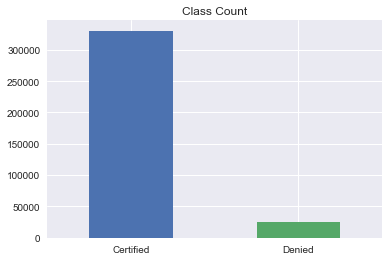

time: 163 ms


In [62]:
number_data.plot(kind='bar', title='Class Count', rot=0);

In [63]:
X=df2.drop(['case_status'], axis=1)
y=df2.case_status

time: 284 ms


In [64]:
Counter(df2.case_status)

Counter({'Certified': 330519, 'Denied': 25649})

time: 38.8 ms


## Undersample

In [65]:
rus = RandomUnderSampler()
X_under, y_under = rus.fit_sample(X,y)

time: 3.87 s


In [66]:
Counter(y_under)

Counter({'Certified': 25649, 'Denied': 25649})

time: 6.51 ms


In [67]:
X_underdf=pd.DataFrame(X_under, columns = X.columns)
y_underdf=pd.DataFrame(y_under, columns=['case_status'])

time: 2.23 ms


In [68]:
df_under=X_underdf.join(y_underdf)

time: 316 ms


In [69]:
df_under.head()

,foreign_worker_info_city,class_of_admission_A-3,class_of_admission_A1/A2,class_of_admission_AOS,class_of_admission_AOS/H-1B,class_of_admission_B-1,class_of_admission_B-2,class_of_admission_C-1,class_of_admission_C-3,class_of_admission_D-1,...,job_category_academic,job_category_business,job_category_engineer,job_category_finance/consulting/tax,job_category_h11,job_category_marketing/sales,job_category_medicine,job_category_programming,job_category_related,case_status
0,300.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Certified
1,5585.211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Certified
2,4062.605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Certified
3,18593.220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Certified
4,2659.134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Certified


time: 23.3 ms


# Store as CSV

In [70]:
# with open('clean_data1.pkl', 'wb') as picklefile:
#              pickle.dump(df_under, picklefile)

time: 556 µs


In [71]:
# with open("clean_data1.pkl", 'rb') as picklefile: 
#       df = pickle.load(picklefile)
# df.to_csv('clean_data1.csv')
# df.head()

time: 609 µs


# Modeling

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import naive_bayes

time: 232 ms


In [73]:
def print_confusion_matrix(confusion_matrix, model, class_names, figsize = (10,7), fontsize=18):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(model)
    return fig

time: 4.05 ms


## Train/Test Split on Random Subset of Data

In [74]:
mini_sample=df_under.sample(n=15000)
X=mini_sample.drop(['case_status'], axis=1)
y=mini_sample.case_status

time: 99.9 ms


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

time: 44.2 ms


In [76]:
train_df=X_train.join(pd.DataFrame(y_train))
test_df=X_test.join(y_test)

time: 28.9 ms


## Apply Standard Scalar

In [77]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

time: 111 ms


In [78]:
train_df_scaled=pd.DataFrame(X_train_scaled).join(y_train)
test_df_sclaed=pd.DataFrame(X_test_scaled).join(y_test)

time: 20 ms


## Make List of Models to Compare

In [79]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None),
          LogisticRegression(C=0.1), SGDClassifier(loss='log', random_state=42, alpha=0.01), naive_bayes.GaussianNB(),
         naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB()]
model_names = ["Random Forest", "Decision Tree",'Logistic','SGD-Log', 'Naive-Bayes Gaussian',
              'Naive-Bayes Bernoulli', 'Naive-Bayes Multinomial']

time: 1.8 ms


## Compare Models- ROC Curves

In [80]:
roc_plotting_stuff = []

for clf, name in zip(models, model_names):
    if 'Bayes' not in name:
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict_proba(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, preds[:,1], pos_label='Denied')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


time: 1.93 s


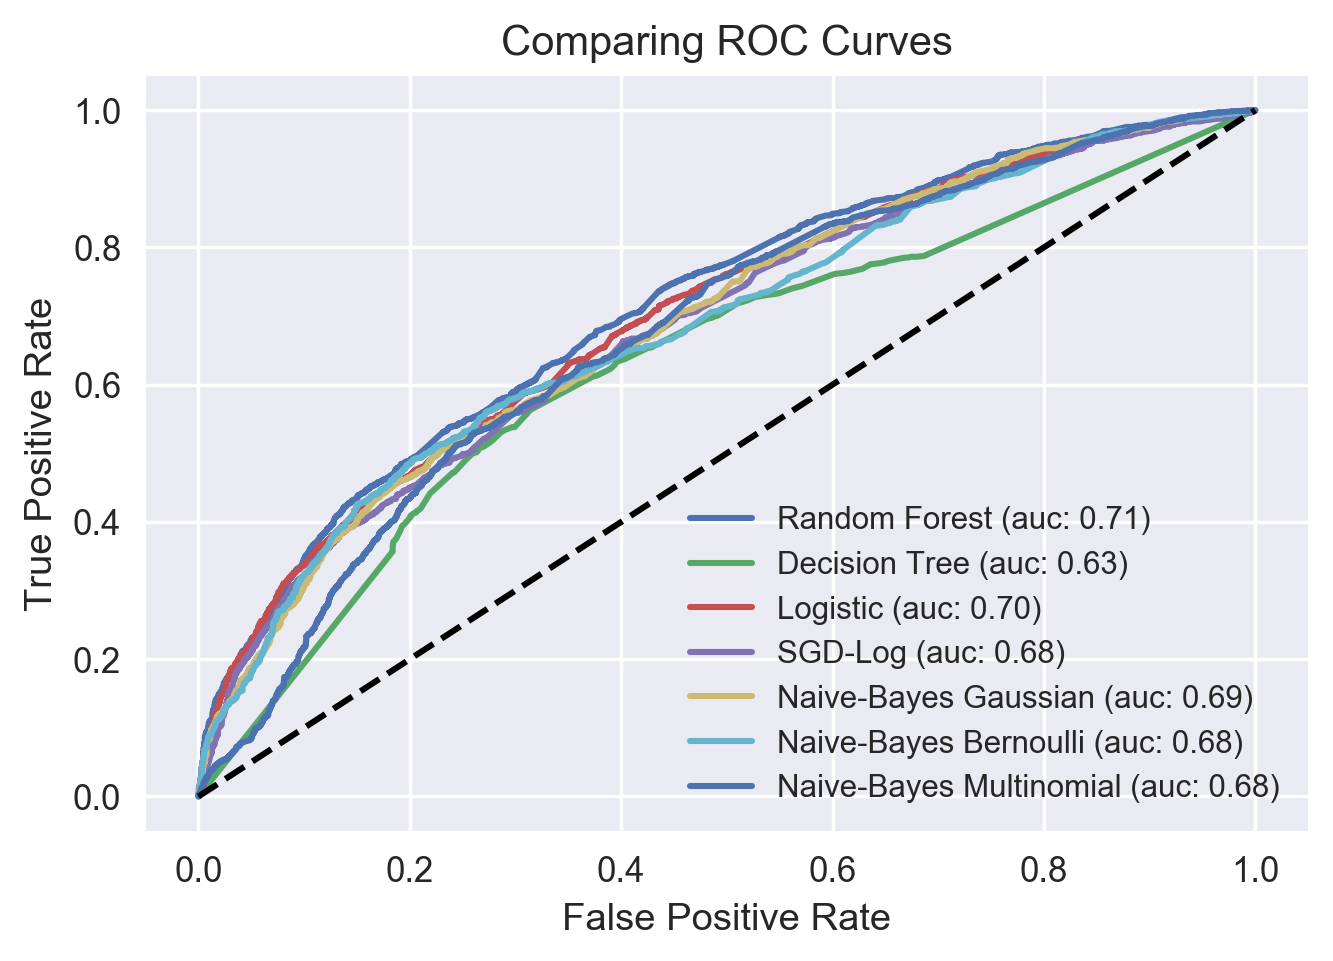

time: 477 ms


In [81]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

## Compare Models- Confusion Matrices

/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


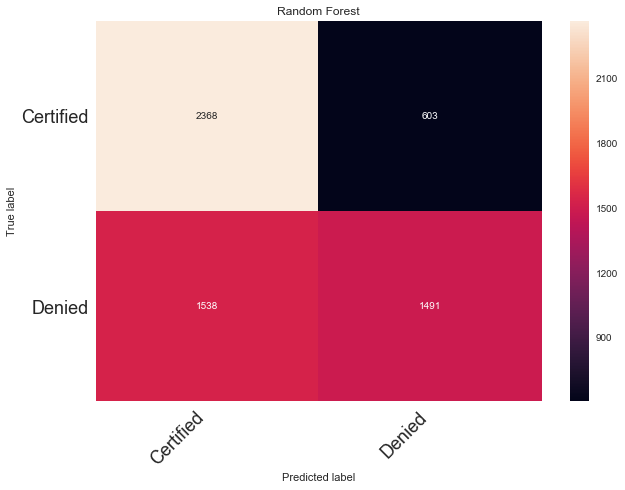

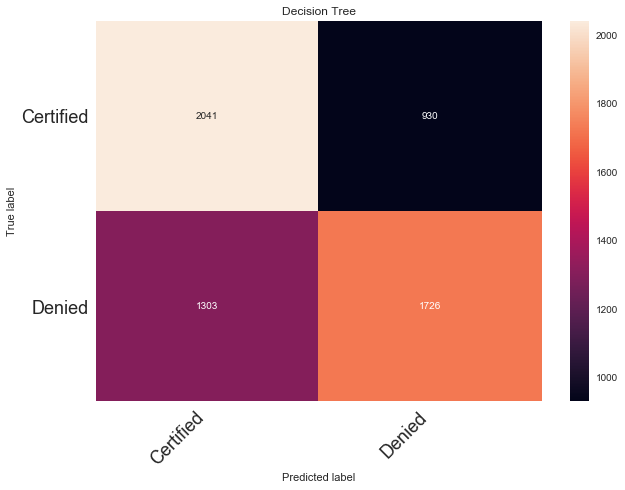

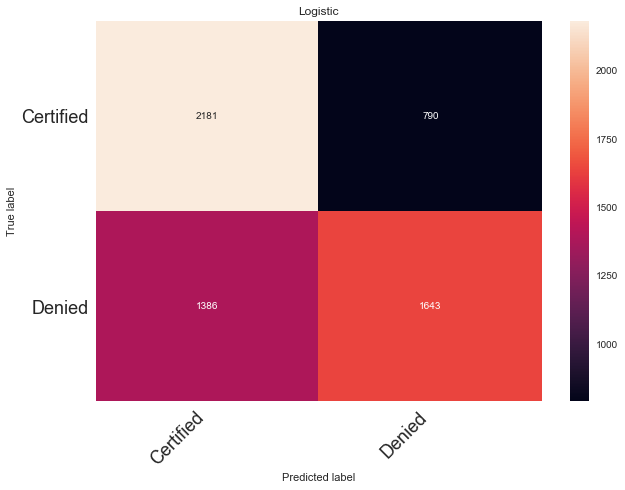

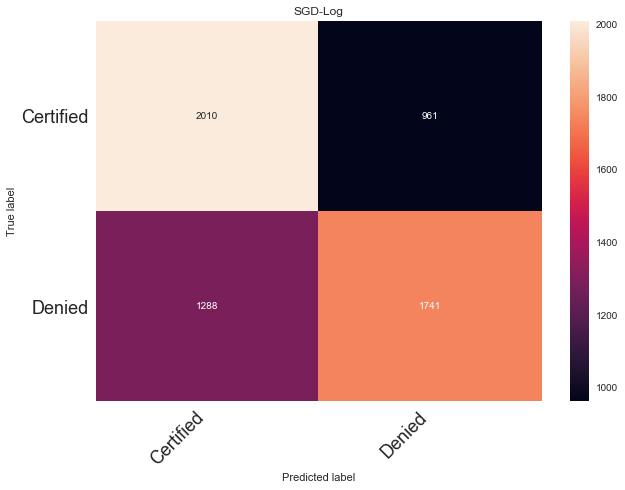

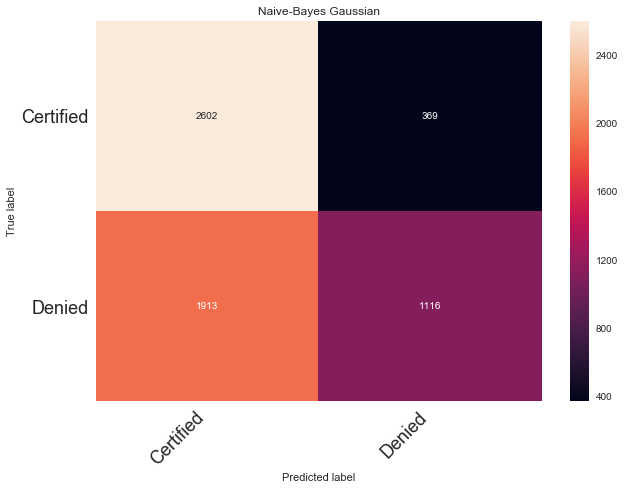

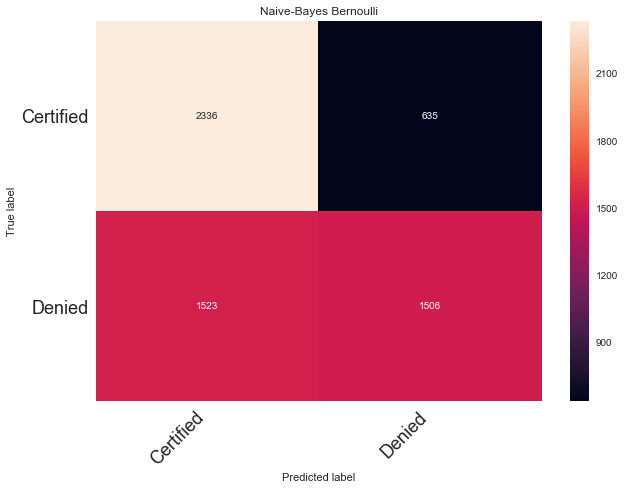

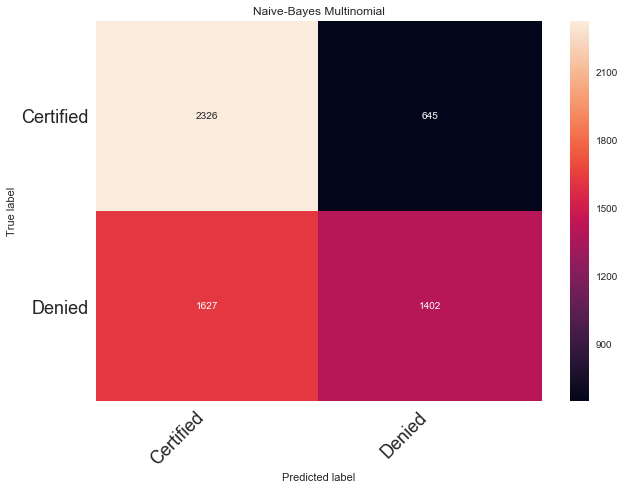

time: 3.17 s


In [85]:
for clf, name in zip(models, model_names):
    if 'Bayes' not in name:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    cm = print_confusion_matrix(conf_mat, name, ['Certified', 'Denied'])

## Which Features are Important

In [84]:
for imp, name in sorted(zip(models[0].feature_importances_, X_train.columns))[-10:]:
    print(f"{name} {imp}")

foreign_worker_info_education_Bachelor's 0.026732227522872982
class_of_admission_Not in USA 0.028871597308656915
job_category_H.14 0.029109994582233886
foreign_worker_info_education_Master's 0.032789638686929544
country_of_citizenship_MEXICO 0.03651641264305711
job_category_programming 0.04381094456940282
foreign_worker_info_education_None 0.06739881724748004
country_of_citizenship_INDIA 0.08682992177141159
foreign_worker_info_city 0.08967297942722259
class_of_admission_H-1B 0.1249723067819401
time: 105 ms


## Apply Chosen Model to Full Train and Score on Test

### Random Forest

In [86]:
rfc=RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

time: 510 ms


In [87]:
y_predict = rfc.predict(X_train)
rfc.score(X_train, y_train)

0.6746666666666666

time: 242 ms


In [88]:
y_predict_test = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.6405

time: 238 ms


### Logistic Regression

In [89]:
lm = LogisticRegression()
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 60.7 ms


In [90]:
y_predict2 = lm.predict(X_train)
lm.score(X_train, y_train)

0.6477777777777778

time: 43.7 ms


In [91]:
y_predict_test2 = lm.predict(X_test)
lm.score(X_test, y_test)

0.6338333333333334

time: 34.9 ms


## Check How Many Data Points are Needed for Final Model

(-1, 1)

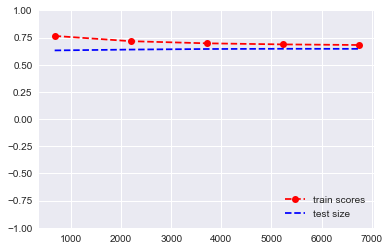

time: 12.5 s


In [92]:
train_sizes, train_scores, test_scores = learning_curve(rfc, X_train, y_train, cv= 4)

ave_train_scores = train_scores.mean(axis=1)
ave_test_scores = test_scores.mean(axis=1)

learn_df = pd.DataFrame({
    'train_size': train_sizes,
    'train_score': ave_train_scores,
    'test_score': ave_test_scores
})
learn_df

plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test size')
plt.legend(loc='lower right')
plt.ylim(-1,1)

This implies that approximately 3000 data points were needed to test this model. Hence the initial random sample  is justified.

# Making Predictions

## Get Predictions

In [133]:
def prediction(features):
    try:
        city_origin=replacements[features['foreign_worker_info_city'].upper()]
    except:
        city_origin=features['foreign_worker_info_city'].upper()
    try:
        city_pop=city_df_dict['pop'][city_origin]
    except:
        city_pop=300.000
    print(city_pop)
    test_case = pd.DataFrame({'class_of_admission': features['class_of_admission'],
                      'country_of_citizenship': features['country_of_citizenship'], 
                      'employer_state': features['employer_state'],
                      'foreign_worker_info_city': city_pop,
                      'foreign_worker_info_education': features['foreign_worker_info_education'],
                      'job_category': features['job_category']}, index=[0])
    
    test_case_dummies=pd.get_dummies(test_case)
    missing_cols=set(X_train.columns) - set(test_case_dummies.columns)
    for c in missing_cols:
        test_case_dummies[c] = 0
    test_case_dummies = test_case_dummies[X_train.columns]
    
    prob_certified = rfc.predict_proba(test_case_dummies)[0, 1] 
    outcome=''
    if int(prob_certified > 0.5):
        outcome+='Certified Visa'
    else:
        outcome+='Denied Visa'
    result = {
        'prediction': outcome,
        'prob_certified': prob_certified
    }
    return result

time: 4.29 ms


In [134]:
example = {
  'class_of_admission': 'H-1B',
  'country_of_citizenship': 'INDIA',
  'employer_state': 'NJ',
  'foreign_worker_info_city': 'NEW YORK',
  'foreign_worker_info_education': 'High School',
  'job_category': 'Other'
}

time: 1.67 ms


In [135]:
prediction(example)

18593.22


{'prediction': 'Certified Visa', 'prob_certified': 0.524360280767735}

time: 239 ms


# You Can't Tell a Story Without a Plot!

In [ ]:
import plotly.plotly as py

## Data Cleaning, Before and After

In [ ]:
df.columns

## Cloropleth

In [ ]:
data = [ dict(
        type = 'choropleth',
        locations = df['CODE'],
        z = df['case_status'],
        text = df['country_of_citizenship'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '$',
            title = 'GDP<br>Billions US$'),
      ) ]

layout = dict(
    title = '2014 Global GDP<br>Source:\
            <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

1. cloropleth
2. flask